# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import pathlib
import seaborn as sns
import ast
from scipy.stats import chi2_contingency
from category_encoders import TargetEncoder
import lightgbm as lgb
import xgboost as xgb




from geopy.geocoders          import Nominatim
from sqlalchemy               import create_engine, text
from matplotlib               import pyplot as plt
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                   import BorutaPy
from sklearn.ensemble         import RandomForestRegressor
from sklearn.model_selection  import train_test_split
from sklearn.linear_model     import LinearRegression,  Lasso
from sklearn.metrics          import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error,r2_score
from sklearn.model_selection  import cross_val_score
from sklearn.preprocessing    import LabelEncoder
from sklearn.model_selection  import KFold

## 0.1.0 Helper Functions

In [2]:
# função para consultar a api passando as coordenadas
def find_mun( lat,long ):
    
    geolocator = Nominatim(user_agent="Oscar")
    
    lat = str( lat )
    
    long = str( long )
    
    coord = lat + ',' + long

    location = geolocator.reverse( coord  )
    
    if 'city_district' in location.raw['address']:
        
        return location.raw['address']['city_district']
        
    if 'suburb' in location.raw['address']:
            
        return location.raw['address']['suburb']
            
    if 'county' in location.raw['address']:
            
        return location.raw['address']['county']
        
    else:
        
        return 'not found'

  
def stats( df , excepto = [] ):
    # separo as feautures numéricas
    if excepto != "":
    
        num_attributes = df.select_dtypes( include = ['int64','float64'] )
        
        num_attributes = num_attributes.drop( excepto , axis = 1 ) 
        
    else:
        
        num_attributes = df.select_dtypes( include = ['int64','float64'] )
    # separo as features categoricas
    num_categorical = df.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )


    # medidas de tendencia central - media e mediana
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T # media

    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T # mediana

    # dispersao - std, min , max , range, skew, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T # std
    d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T # minimo
    d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T # maximo
    d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T # range
    d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T # skew
    d6 = pd.DataFrame( num_attributes.apply( lambda x : x.kurtosis() ) ).T # kurtosis

    # concatenate - min , max , range,  media, median, std, skew , kurtosis
    m = pd.concat( [ d2 , d3, d4 , ct1 , ct2 , d1,  d5 , d6 ] ).T.reset_index()
    m.columns = [ 'features', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
    pd.set_option( 'display.float_format', '{:,.2f}'.format )
    return m

def ml_error( model_name, y , y_hat):
    mae =  mean_absolute_error( y , y_hat )
    mape = mean_absolute_percentage_error( y , y_hat )
    rmse = np.sqrt( mean_squared_error( y , y_hat ) )
    r2 =   r2_score(y, y_hat)
    df = pd.DataFrame( {'Model Name ' :  model_name,
                        'MAE' : mae ,
                        'MAPE' : mape,
                        'RMSE' : rmse,
                        'R2_score' : r2  } ,index = [0] )
    
    return df

def remover_outliers( df, coluna ):
    
    linhas_iniciais = df.shape[0] 
    
    
    d1 = df[coluna].quantile(0.25)
    d3 = df[coluna].quantile(0.75)

    lim_superior = d3 + 1.5*( d3 - d1  )

    lim_inferior = d1 - 1.5 * ( d3 - d1 )
    
    
    df = df.loc[ (df[coluna] >= lim_inferior) & (df[coluna] <= lim_superior) , :  ]
    
    linhas_finais = df.shape[0]
    
    
    print('Foram removidas {} linhas'.format( linhas_iniciais - linhas_finais ) )
          
    return df

def cramer_v( x, y ):
    cm = pd.crosstab( x , y ).values

    n = cm.sum()

    r,k = cm.shape

    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - (k-1) * (r-1) / (n-1) ) # chi2 corrigido
    kcorr = k - (k-1)**2 / (n-1) # k corrigido
    rcorr = r - (k-1)**2 / (n-1) # r corrigido
    
    v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
    
    return v

## 0.2.0. Loading Data

In [3]:
# caminho
caminho = pathlib.Path('data')

df = []

for arquivo in caminho.iterdir():
    print(arquivo.name)
    
    # ler o arquivo
    df_read = pd.read_excel( arquivo )
    
    # apender o df
    df.append(df_read)

# concatena os df's
df_raw = pd.concat( df )

df_raw = df_raw[['propertyCode', 'thumbnail', 'numPhotos', 'floor', 'price',
       'propertyType', 'operation', 'size', 'exterior', 'rooms', 'bathrooms',
       'address', 'province', 'municipality', 'district', 'country',
       'latitude', 'longitude', 'showAddress', 'url', 'distance',
       'description', 'hasVideo', 'status', 'newDevelopment', 'hasLift',
       'priceByArea', 'detailedType', 'suggestedTexts', 'hasPlan', 'has3DTour',
       'has360', 'hasStaging', 'topNewDevelopment', 'superTopHighlight',
       'parkingSpace', 'externalReference', 'labels', 'neighborhood', 'pagina',
       'datetime_scrapy', 'newDevelopmentFinished', 'highlight']]

# resetar index
df_raw = df_raw.reset_index( drop = True )

extracao_12_4_2023.xlsx
extracao_1_1_2023.xlsx
extracao_1_9_2023.xlsx
extracao_26_1_2024.xlsx
extracao_2_2_2023.xlsx
extracao_2_6_2023.xlsx
extracao_3_3_2023.xlsx
extracao_6_7_2023.xlsx


## 0.2.1 Separar Dados de Teste

In [4]:
# Separar Dados de Teste
divisor = df_raw.shape[0] - 2000
df_teste = df_raw.iloc[ divisor: ] # pego 1000 linhas para teste

In [5]:
# separar dados brutos
df_raw = df_raw.iloc[:divisor]

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## Explicação das colunas

* property_code - ID unico para cada imovel


* thumbnail - mostra a thumbnail do imovel


* external_reference - A feature "external_reference" geralmente se refere a um código único atribuído a um imóvel por outra fonte, como outra plataforma imobiliária ou um agente imobiliário. Essa referência externa pode ser usada para rastrear e identificar o imóvel em diferentes sistemas e plataformas.


* num_photos - número de fotos do anúncio


* price - preço da renda


* property_type - tipo de propriedade


* operation - renda ou venda ( nesse caso tenho somente renda )


* size - tamanho em m2


* exterior - deve ser se o imóvel tem área exterior ( array([ 0., nan]) 


* rooms - quantidade de quartos


* bathrooms - quantidade de casas de banho


* address - endereço do imóvel


* province - são as regiões ( Lisboa, Setúbal, Santarém - vieram na extração )


* municipality - municipios


* district - são os Distritos


* country - PT 


* latitude - latitude


* longitude - longitude


* show_address - boolean - se o anunciante exibe o endereço


* url - a url do anuncio


* distance - distancia do centro em m


* description - descricao do apartamento


* has_video - diz se o anuncio tem vídeo ou não ( array([ 0.,  1., nan]) )


* status - diz sobre o estado do imóvel array(['good', 'renew', 'newdevelopment', None], dtype=object)


* new_development - boolean - diz se o empreendimento é novo ou não 


* price_by_area - preco divido pelo tamanho do imóvel price / size


* detailed_type - descrição detalhada do tipo de imóvel


* suggested_texts - títulos e subtítulos


* has_plan - se o imóvel tem plano ou não


* has3_d_tour - indica se o imóvel tem tour 3d


* has360 - se tem tour 360º


* has_staging - se tem uma decoração na propriedade


* top_new_development - indica os empreendimentos mais novos


* super_top_highlight - indica os imóveis mais valiosos ou populares em uma determinada área


* floor - indica o andar do imóvel


* has_lift - indica se tem elevador


* parking_space - indica se tem vaga de garagem


* neighborhood - Essa feature é útil para compradores e inquilinos que têm preferência por um determinado bairro ou querem morar em uma área específica da cidade por motivos como proximidade do trabalho, escolas, transporte público, entre outros.


* labels - etiquetas ou rótulos associados aos imoveis


* pagina - a pagina da extração ( definida na extração )


* datetime_scrapy - indica a data da extração ( definida na extração )


* newDevelopmentFinished - 


* highlight - 

## 1.1. Rename Columns

In [7]:
cols_old = [ 'propertyCode', 'thumbnail', 'numPhotos', 'floor', 'price',
       'propertyType', 'operation', 'size', 'exterior', 'rooms', 'bathrooms',
       'address', 'province', 'municipality', 'district', 'country',
       'latitude', 'longitude', 'showAddress', 'url', 'distance',
       'description', 'hasVideo', 'status', 'newDevelopment', 'hasLift',
       'priceByArea', 'detailedType', 'suggestedTexts', 'hasPlan', 'has3DTour',
       'has360', 'hasStaging', 'topNewDevelopment', 'superTopHighlight',
       'parkingSpace', 'externalReference', 'labels', 'neighborhood', 'pagina',
       'datetime_scrapy', 'newDevelopmentFinished', 'highlight']

# def função snake_case
snake_case = lambda x: inflection.underscore( x )

# defino as novas colunas
cols_new = list(map( snake_case, cols_old )) 

df1.columns = cols_new

df1 = df1.loc[~ df1['property_code'].isna() , : ]

## 1.1.2 Drop Duplicates

In [8]:
df1 = df1.drop_duplicates( subset= ['property_code'], keep = 'last' )

## 1.2. Data Dimensions

In [9]:
print( 'Number of rows {:,}'.format( df1.shape[0] ) )
print( 'Number of columns {:,}'.format( df1.shape[1] ) )

Number of rows 11,179
Number of columns 43


## 1.3. Data Types

In [10]:
# exibindo os tipos de dados
print( df1.dtypes )

property_code               float64
thumbnail                    object
num_photos                  float64
floor                        object
price                       float64
property_type                object
operation                    object
size                        float64
exterior                     object
rooms                       float64
bathrooms                   float64
address                      object
province                     object
municipality                 object
district                     object
country                      object
latitude                    float64
longitude                   float64
show_address                 object
url                          object
distance                    float64
description                  object
has_video                    object
status                       object
new_development              object
has_lift                    float64
price_by_area               float64
detailed_type               

## 1.4. Check NA

In [11]:
df1.isna().sum()

property_code                   0
thumbnail                      23
num_photos                      0
floor                        4956
price                           0
property_type                   0
operation                       0
size                            0
exterior                     5463
rooms                           0
bathrooms                       0
address                         0
province                        0
municipality                    0
district                     1300
country                         0
latitude                        0
longitude                       0
show_address                    0
url                             0
distance                        0
description                    15
has_video                       0
status                          0
new_development                 0
has_lift                     3545
price_by_area                   0
detailed_type                   0
suggested_texts                 0
has_plan      

In [12]:
# calculando os % de dados vazios
dfna = df1.isna().sum().to_frame().reset_index()
dfna['% dados Vazios'] = ( df1.isna().sum().to_frame().reset_index()[0] / df1.shape[0] ) *100
dfna.loc[ dfna['% dados Vazios'] != 0 , : ]

,index,0,% dados Vazios
1,thumbnail,23,0.205743
3,floor,4956,44.333125
8,exterior,5463,48.868414
14,district,1300,11.628947
21,description,15,0.134180
25,has_lift,3545,31.711244
34,super_top_highlight,3735,33.410860
35,parking_space,7858,70.292513
36,external_reference,1651,14.768763
37,labels,7804,69.809464


## 1.5. Fillout NA

In [13]:
def fill_na(df):
    # thumbnail - vou substituir anúncios que possuem thumbnail por 1 e aqueles que não por 0
    df.loc[:,'thumbnail'] = np.where( df['thumbnail'].isna(), 0 , 1 )

    # floor 
    df.loc[:,'floor'] = df['floor'].apply( lambda x : 0 if pd.isna( x ) else x )

    # district - vou fazer uma chamada na api para procurar os districts passando as coordenadas
    df.loc[:,'district'] = df.apply(lambda x: find_mun( x['latitude'], x['longitude'] ) if pd.isna( x['district'] ) else x['district'],axis = 1)

    # description
    df.loc[:,'description'] = df['description'].apply( lambda x : 'no description' if pd.isna( x ) else x )

    # has_lift - vou considerar que se não foi informado na base o apto imovel não tem elevador
    df.loc[:,'has_lift'] = df['has_lift'].apply( lambda x: 0 if pd.isna( x ) else x  )

    # parking_space 
    df.loc[:,'parking_space'] = df['parking_space'].apply( lambda x: 0 if pd.isna( x ) else x ) 
    
    return df

In [14]:
df1 = fill_na( df1 )

C:\Users\oscar\AppData\Local\Temp\ipykernel_7416\2764531685.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'thumbnail'] = np.where( df['thumbnail'].isna(), 0 , 1 )


## 1.5.1 - Excluindo colunas irrelevantes

In [15]:
# função para excluir colunas se for passada uma lista
def delete_columns( df , list_columns = None ):
    
    if list_columns is None:
        
        df = df
        
        return df
    
    else:
        
        df = df.drop( list_columns , axis = 1)
        
        return df


In [16]:
# colunas vazias ou irrelevantes
colunas_irrelevantes = ['property_code',
           'external_reference',
           'labels',
           'neighborhood',
           'new_development_finished',
           'highlight',
           'exterior',
           'super_top_highlight',
           'operation',
           'country',
           'url',
           'price_by_area']

df1 = delete_columns( df1 , colunas_irrelevantes )

## 1.7. Descriptive Statistical

## 1.7.1 Numerical Attributes

In [17]:
df1_stats = stats( df1 , ['latitude','longitude','pagina'] )
df1_stats

,features,min,max,range,mean,median,std,skew,kurtosis
0,num_photos,0.00,129.00,129.00,24.90,23.00,13.01,1.49,4.69
1,price,300.00,"80,000.00","79,700.00","2,843.00","2,000.00","2,729.84",5.30,74.39
2,size,10.00,"97,500.00","97,490.00",152.43,110.00,980.23,90.57,"8,791.07"
3,rooms,0.00,21.00,21.00,2.52,2.00,1.35,1.49,9.80
4,bathrooms,1.00,14.00,13.00,2.04,2.00,1.21,1.84,5.90
5,distance,61.00,"49,801.00","49,740.00","11,225.52","6,758.00","10,332.27",0.81,-0.40
6,has_lift,0.00,1.00,1.00,0.45,0.00,0.50,0.19,-1.96


## 1.7.2 Categorical Attributes

In [18]:
df1['province'] = df1['province'].apply( lambda x : 'Lisboa' if x == 'lisboa' else 'Setúbal' if x == 'setubal' else 'Santarém' if x == 'santarem'  else x)

num_categorical = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )
# verifico quantos tipos diferentes tenho nas var categoricas
print( num_categorical.apply( lambda x: x.unique().shape[0] ) )

print( '='*100 )

# verifico quantos tipos diferentes tenho nas var categoricas
print( num_categorical.apply( lambda x: x.unique() ) )

thumbnail                  2
floor                     32
property_type              6
address                 3808
province                   3
municipality             138
district                 403
show_address               2
description            10893
has_video                  2
status                     3
new_development            2
detailed_type             15
suggested_texts         4205
has_plan                   2
has3_d_tour                2
has360                     2
has_staging                2
top_new_development        1
parking_space             14
datetime_scrapy          111
dtype: int64
thumbnail                                                         [1, 0]
floor                  [6, 2, bj, 0, 1, 3, 8, 5, 7, en, 16, 4, 12, 11...
property_type          [flat, chalet, duplex, studio, penthouse, coun...
address                [Nova Carnaxide, Rua Professor Doutor João Bat...
province                                     [Lisboa, Setúbal, Santarém]
municipality 

# 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

In [20]:
# será usado para médias das regiões
df2.to_csv( 'datasets/df_region.csv' )

In [21]:
def feature_engineering( df , df_region, transform_data = False, merge_datasets = False ):
    
    if transform_data and merge_datasets == False :
        
        # mes
        df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
        df['month'] = df['datetime_scrapy'].dt.month 

        # ano
        df['year'] = df['datetime_scrapy'].dt.year

        # excluir a coluna datetime
        df = df.drop( 'datetime_scrapy', axis = 1 )
        
        print( 'Dados Transformados' )
        
        return df
        
    
    if merge_datasets == True and transform_data == False:
        
        # Df com a média de preço por município
        df_municipality_mean_price = df_region.groupby('municipality')[['price']].mean().reset_index()

        # alteração nome coluna
        df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

        # exportar para csv
        #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

        # acrescentando a coluna ao df2
        df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )

# ======================================================================================================================#

        # calculando a média por 'province'
        df2_province_mean_price = df_region.groupby( 'province' )[['price']].mean().reset_index().rename( columns = { 'price': 'province_mean_price' } )

        # exportando para csv
        # df2_province_mean_price.to_csv( 'datasets/province.csv' )

        # acrescentando a coluna ao df2
        df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )

#=======================================================================================================================#

        # calculando média por district
        df2_district_mean_price = df_region.groupby( 'district' )[['price']].median().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

        # exportando para csv 
        #df2_district_mean_price.to_csv( 'datasets/district.csv' )

        # acrescentando a coluna ao df2
        df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )

        print( 'Datasets combinados com preços regioes' )

        return df
    
    if transform_data == True and merge_datasets == True:
        
        # mes
        df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
        df['month'] = df['datetime_scrapy'].dt.month 

        # ano
        df['year'] = df['datetime_scrapy'].dt.year

        # excluir a coluna datetime
        df = df.drop( 'datetime_scrapy', axis = 1 )
        
        # Df com a média de preço por município
        df_municipality_mean_price = df_region.groupby('municipality')[['price']].mean().reset_index()

        # alteração nome coluna
        df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

        # exportar para csv
        #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

        # acrescentando a coluna ao df2
        df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )
        
# ======================================================================================================================#
        
        # calculando a média por 'province'
        df2_province_mean_price = df_region.groupby( 'province' )[['price']].mean().reset_index().rename( columns = { 'price': 'province_mean_price' } )

        # exportando para csv
        # df2_province_mean_price.to_csv( 'datasets/province.csv' )

        # acrescentando a coluna ao df2
        df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )
        
#=======================================================================================================================#
        
        # calculando média por district
        df2_district_mean_price = df_region.groupby( 'district' )[['price']].median().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

        # exportando para csv 
        #df2_district_mean_price.to_csv( 'datasets/district.csv' )

        # acrescentando a coluna ao df2
        df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )
        
        print( 'datasets combinados e dados transformados' )
        
        return df
        
    else:
        
        print( 'Nenhuma Transformação' )
        
        return df
            

In [22]:
df_mean_region = pd.read_csv( 'datasets/df_region.csv' )


df2 = feature_engineering( df = df2 ,  
                          df_region= df_mean_region, merge_datasets= True, transform_data= True)


datasets combinados e dados transformados


# 3.0 Filtragem de Variáveis

In [23]:
df3 = df2.copy()

In [24]:
def filter_variables(df, filter_variables = False):
    
    if filter_variables:
        
        # Vou querer saber somente os preços na province de Lisboa
        df = df.loc[ df['province'] == 'Lisboa' , :  ]

        # vou querer somente as habitações que tenham de 0 a no máximo 4 quartos
        df = df.loc[ df['rooms'].isin( [ 0,1,2,3,4 ] ) , : ]
        
        print('Variavies filtradas')
        
        return df
    
    else:
        
        print('Variavies não filtradas')
        
        return df

        
    

In [25]:
# vou manter filter_variables = False neste ciclo
df3 = filter_variables( df3 )

Variavies não filtradas


# 4.0 Análise Exploratória de Dados

In [26]:
df4 = df3.copy()

## 4.1. - Analise Univariada

In [27]:
# verifico as informações estatísticas
stats( df4 , ['latitude','longitude'])

,features,min,max,range,mean,median,std,skew,kurtosis
0,num_photos,0.00,129.00,129.00,24.90,23.00,13.01,1.49,4.69
1,price,300.00,"80,000.00","79,700.00","2,843.00","2,000.00","2,729.84",5.30,74.39
2,size,10.00,"97,500.00","97,490.00",152.43,110.00,980.23,90.57,"8,791.07"
3,rooms,0.00,21.00,21.00,2.52,2.00,1.35,1.49,9.80
4,bathrooms,1.00,14.00,13.00,2.04,2.00,1.21,1.84,5.90
5,distance,61.00,"49,801.00","49,740.00","11,225.52","6,758.00","10,332.27",0.81,-0.40
6,has_lift,0.00,1.00,1.00,0.45,0.00,0.50,0.19,-1.96
7,pagina,1.00,92.00,91.00,29.26,25.00,22.53,0.96,0.25
8,month,1.00,9.00,8.00,3.72,3.00,2.94,0.66,-0.98
9,year,"2,023.00","2,024.00",1.00,"2,023.33","2,023.00",0.47,0.70,-1.51


In [28]:
# removendo o imóvel de tamanho 97500 m2
df4 = df4.loc[ df4['size'] != 97500 , : ]

In [29]:
# verifico novamente as informações estatísticas
stats( df4 , ['latitude','longitude'])

,features,min,max,range,mean,median,std,skew,kurtosis
0,num_photos,0.00,129.00,129.00,24.90,23.00,13.01,1.49,4.69
1,price,300.00,"80,000.00","79,700.00","2,843.13","2,000.00","2,729.93",5.30,74.39
2,size,10.00,"30,940.00","30,930.00",143.72,110.00,336.26,72.95,"6,417.69"
3,rooms,0.00,21.00,21.00,2.52,2.00,1.35,1.49,9.80
4,bathrooms,1.00,14.00,13.00,2.04,2.00,1.21,1.84,5.89
5,distance,61.00,"49,801.00","49,740.00","11,225.12","6,756.50","10,332.65",0.81,-0.40
6,has_lift,0.00,1.00,1.00,0.45,0.00,0.50,0.19,-1.96
7,pagina,1.00,92.00,91.00,29.26,25.00,22.52,0.96,0.25
8,month,1.00,9.00,8.00,3.72,3.00,2.94,0.66,-0.98
9,year,"2,023.00","2,024.00",1.00,"2,023.33","2,023.00",0.47,0.70,-1.50


### 4.1.1 - Response Variable

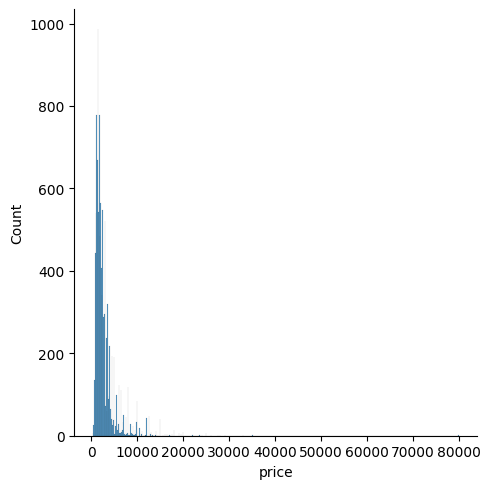

In [30]:
# variavael resposta normal
sns.displot( df4['price'] )

In [31]:
# função para remover outliers
def remove_outliers(df, coluna = None ,  keep_outliers = True ):
    
    if keep_outliers:
        print( 'Outliers mantidos' )
        return df
        
    else:
        # variavel resposta sem outliers
        df = remover_outliers( df4 , coluna )
        print('Outliers removidos')
        return df

In [32]:
# manter os outliers
df4 = remove_outliers( df4 )


Outliers mantidos


### 4.1.2 - Numerical Variable

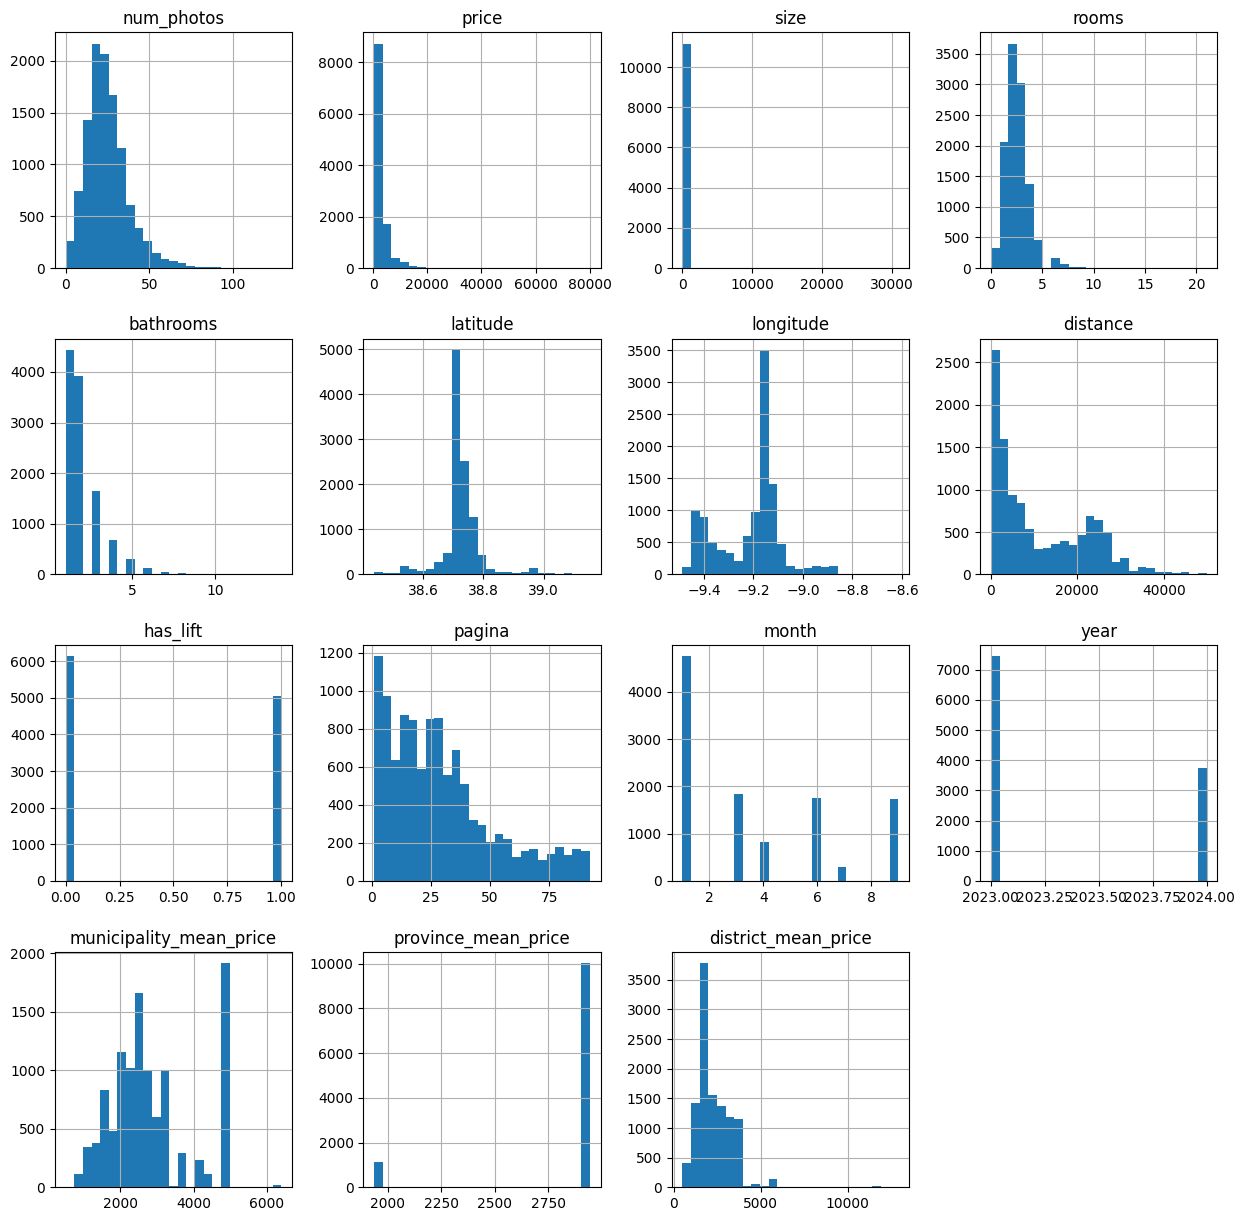

In [33]:
df4_num_attributes = df4.select_dtypes( include = ['int64','float64'] )
df4_num_attributes.hist( bins = 25, figsize=( 15,15 ) );

## 4.2. -  Análise Bivariada

### 4.2.1 - Correlação entre Atributos Numéricos

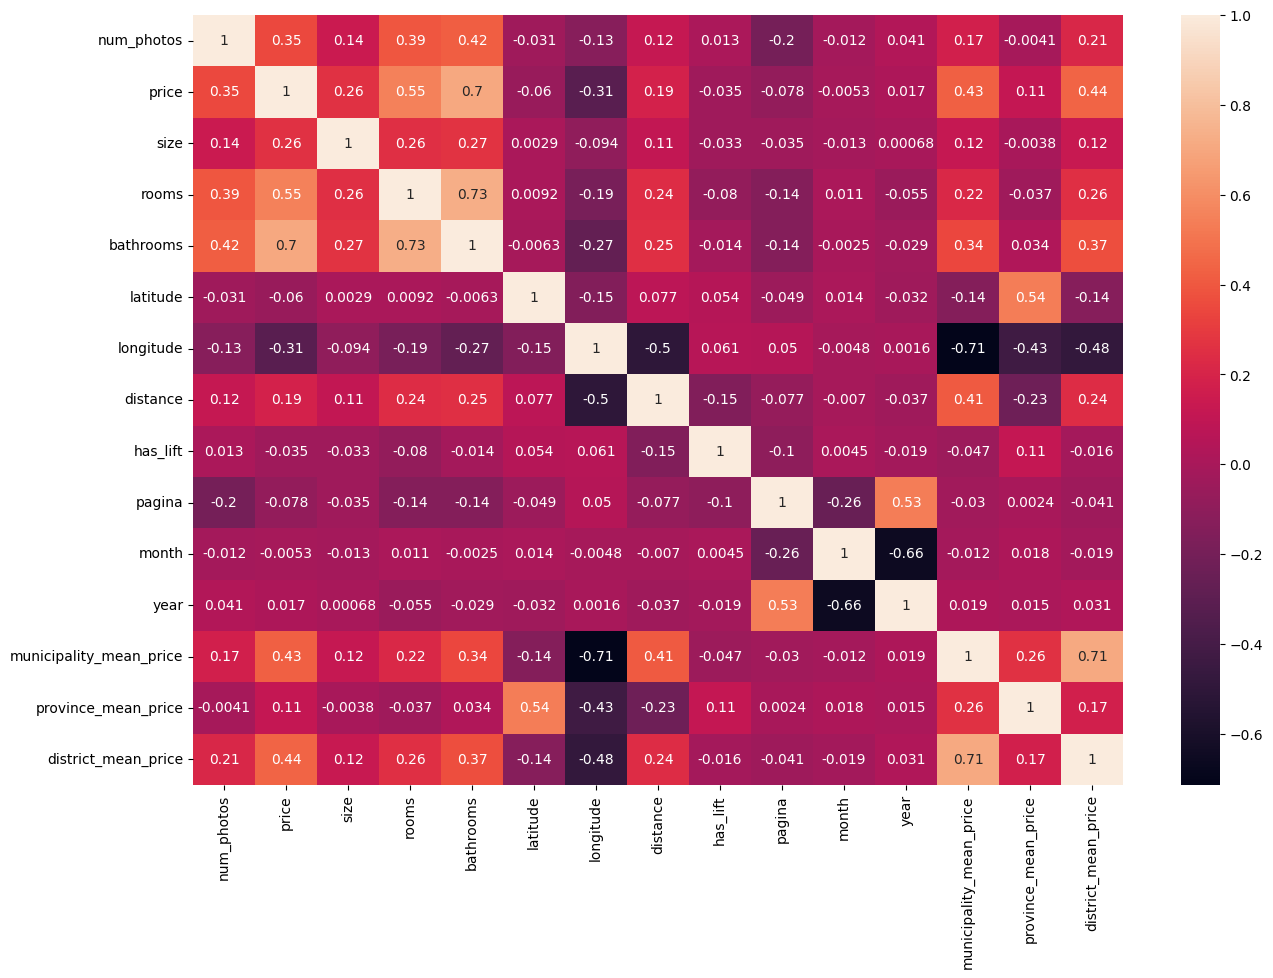

In [34]:
plt.figure( figsize = (15,10) )
correlation = df4_num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

### 4.2.2 - Correlação entre Atributos Categóricos

In [35]:
a = df4.select_dtypes( include = ['object'] ) # pego o df mais atualizado

# aplico a função cramer v nas variáveis categoricas
a1 = cramer_v( a['floor'] , a['floor'] )
a2 = cramer_v( a['floor'], a['property_type'] )
a3 = cramer_v( a['floor'], a['address'] )
a4 = cramer_v( a['floor'], a['province'] )
a5 = cramer_v( a['floor'], a['municipality'] )
a6 = cramer_v( a['floor'], a['district'] )
a7 = cramer_v( a['floor'], a['description'] )
a8 = cramer_v( a['floor'], a['status'] )
a9 = cramer_v( a['floor'], a['detailed_type'] )
a10 = cramer_v( a['floor'], a['suggested_texts'] )
a11 = cramer_v( a['floor'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a12= cramer_v( a['property_type'], a['floor'] )
a13= cramer_v( a['property_type'], a['property_type'] )
a14= cramer_v( a['property_type'], a['address'] )
a15= cramer_v( a['property_type'], a['province'] )
a16= cramer_v( a['property_type'], a['municipality'] )
a17= cramer_v( a['property_type'], a['district'] )
a18= cramer_v( a['property_type'], a['description'] )
a19= cramer_v( a['property_type'], a['status'] )
a20= cramer_v( a['property_type'], a['detailed_type'] )
a21=cramer_v(  a['property_type'], a['suggested_texts'] )
a22=cramer_v(  a['property_type'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a23= cramer_v( a['address'], a['floor'] )
a24= cramer_v( a['address'], a['property_type'] )
a25= cramer_v( a['address'], a['address'] )
a26= cramer_v( a['address'], a['province'] )
a27= cramer_v( a['address'], a['municipality'] )
a28= cramer_v( a['address'], a['district'] )
a29= cramer_v( a['address'], a['description'] )
a30= cramer_v( a['address'], a['status'] )
a31= cramer_v( a['address'], a['detailed_type'] )
a32=cramer_v(  a['address'], a['suggested_texts'] )
a33=cramer_v(  a['address'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a34= cramer_v( a['province'], a['floor'] )
a35= cramer_v( a['province'], a['property_type'] )
a36= cramer_v( a['province'], a['address'] )
a37= cramer_v( a['province'], a['province'] )
a38= cramer_v( a['province'], a['municipality'] )
a39= cramer_v( a['province'], a['district'] )
a40= cramer_v( a['province'], a['description'] )
a41= cramer_v( a['province'], a['status'] )
a42= cramer_v( a['province'], a['detailed_type'] )
a43=cramer_v(  a['province'], a['suggested_texts'] )
a44=cramer_v(  a['province'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a45= cramer_v( a['municipality'], a['floor'] )
a46= cramer_v( a['municipality'], a['property_type'] )
a47= cramer_v( a['municipality'], a['address'] )
a48= cramer_v( a['municipality'], a['province'] )
a49= cramer_v( a['municipality'], a['municipality'] )
a50= cramer_v( a['municipality'], a['district'] )
a51= cramer_v( a['municipality'], a['description'] )
a52= cramer_v( a['municipality'], a['status'] )
a53= cramer_v( a['municipality'], a['detailed_type'] )
a54=cramer_v(  a['municipality'], a['suggested_texts'] )
a55=cramer_v(  a['municipality'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a56= cramer_v( a['district'], a['floor'] )
a57= cramer_v( a['district'], a['property_type'] )
a58= cramer_v( a['district'], a['address'] )
a59= cramer_v( a['district'], a['province'] )
a60= cramer_v( a['district'], a['municipality'] )
a61= cramer_v( a['district'], a['district'] )
a62= cramer_v( a['district'], a['description'] )
a63= cramer_v( a['district'], a['status'] )
a64= cramer_v( a['district'], a['detailed_type'] )
a65=cramer_v(  a['district'], a['suggested_texts'] )
a66=cramer_v(  a['district'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a67= cramer_v( a['description'], a['floor'] )
a68= cramer_v( a['description'], a['property_type'] )
a69= cramer_v( a['description'], a['address'] )
a70= cramer_v( a['description'], a['province'] )
a71= cramer_v( a['description'], a['municipality'] )
a72= cramer_v( a['description'], a['district'] )
a73= cramer_v( a['description'], a['description'] )
a74= cramer_v( a['description'], a['status'] )
a75= cramer_v( a['description'], a['detailed_type'] )
a76=cramer_v(  a['description'], a['suggested_texts'] )
a77=cramer_v(  a['description'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a78= cramer_v( a['status'], a['floor'] )
a79= cramer_v( a['status'], a['property_type'] )
a80= cramer_v( a['status'], a['address'] )
a81= cramer_v( a['status'], a['province'] )
a82= cramer_v( a['status'], a['municipality'] )
a83= cramer_v( a['status'], a['district'] )
a84= cramer_v( a['status'], a['description'] )
a85= cramer_v( a['status'], a['status'] )
a86= cramer_v( a['status'], a['detailed_type'] )
a87=cramer_v(  a['status'], a['suggested_texts'] )
a88=cramer_v(  a['status'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a89= cramer_v( a['detailed_type'], a['floor'] )
a90= cramer_v( a['detailed_type'], a['property_type'] )
a91= cramer_v( a['detailed_type'], a['address'] )
a92= cramer_v( a['detailed_type'], a['province'] )
a93= cramer_v( a['detailed_type'], a['municipality'] )
a94= cramer_v( a['detailed_type'], a['district'] )
a95= cramer_v( a['detailed_type'], a['description'] )
a96= cramer_v( a['detailed_type'], a['status'] )
a97= cramer_v( a['detailed_type'], a['detailed_type'] )
a98=cramer_v(  a['detailed_type'], a['suggested_texts'] )
a99=cramer_v(  a['detailed_type'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a100= cramer_v( a['suggested_texts'], a['floor'] )
a101= cramer_v( a['suggested_texts'], a['property_type'] )
a102= cramer_v( a['suggested_texts'], a['address'] )
a103= cramer_v( a['suggested_texts'], a['province'] )
a104= cramer_v( a['suggested_texts'], a['municipality'] )
a105= cramer_v( a['suggested_texts'], a['district'] )
a106= cramer_v( a['suggested_texts'], a['description'] )
a107= cramer_v( a['suggested_texts'], a['status'] )
a108= cramer_v( a['suggested_texts'], a['detailed_type'] )
a109=cramer_v(  a['suggested_texts'], a['suggested_texts'] )
a110=cramer_v(  a['suggested_texts'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a111= cramer_v( a['parking_space'], a['floor'] )
a112= cramer_v( a['parking_space'], a['property_type'] )
a113= cramer_v( a['parking_space'], a['address'] )
a114= cramer_v( a['parking_space'], a['province'] )
a115= cramer_v( a['parking_space'], a['municipality'] )
a116= cramer_v( a['parking_space'], a['district'] )
a117= cramer_v( a['parking_space'], a['description'] )
a118= cramer_v( a['parking_space'], a['status'] )
a119= cramer_v( a['parking_space'], a['detailed_type'] )
a120=cramer_v(  a['parking_space'], a['suggested_texts'] )
a121=cramer_v(  a['parking_space'], a['parking_space'] )



d = pd.DataFrame( {'floor' : [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11],
                   'property_type' : [a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22],
                   'address' : [a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33],
                   'province' : [a34,a35,a36,a37,a38,a39,a40,a41,a42,a43,a44],
                   'municipality' : [a45,a46,a47,a48,a49,a50,a51,a52,a53,a54,a55],
                   'district' : [a56,a57,a58,a59,a60,a61,a62,a63,a64,a65,a66],
                   'description' : [a67,a68,a69,a70,a71,a72,a73,a74,a75,a76,a77],
                   'status' : [a78,a79,a80,a81,a82,a83,a84,a85,a86,a87,a88],
                   'detailed_type' : [a89,a90,a91,a92,a93,a94,a95,a96,a97,a98,a99],
                   'suggested_texts' : [a100,a101,a102,a103,a104,a105,a106,a107,a108,a109,a110],
                   'parking_space' : [a111,a112,a113,a114,a115,a116,a117,a118,a119,a120,a121]
              
              } )

d = d.set_index( d.columns )
d = d.drop( 'province', axis = 1 )

C:\Users\oscar\AppData\Local\Temp\ipykernel_7416\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_7416\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_7416\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_7416\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_7416\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_7416\3203194230.py:112: RuntimeWarning: i

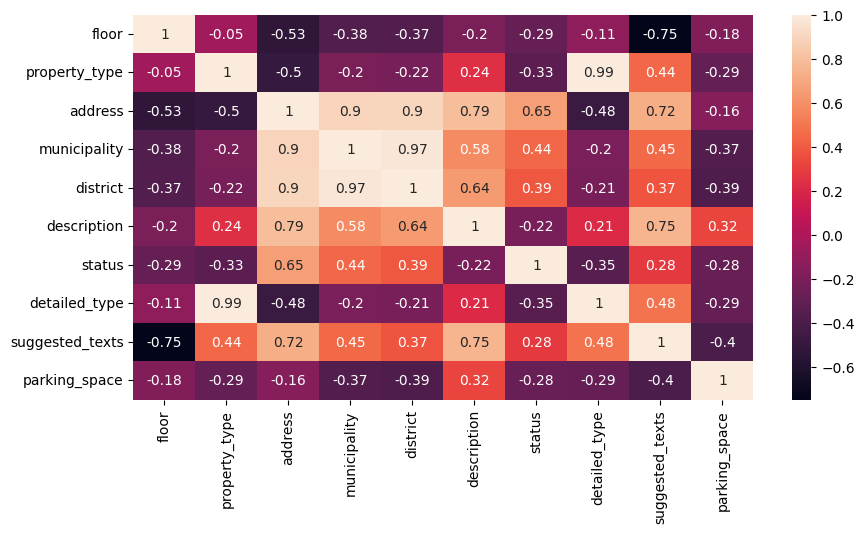

In [36]:
plt.figure(figsize=(10,5))
correlation = d.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

# Data Preparation

In [37]:
df5 = df4.copy()

## 5.1. - Rescaling

In [38]:
def rescaling_data(df, rescale = False ):
    
    if rescale:
        rs = RobustScaler() # usado para variáveis que tem outliers
        mms = MinMaxScaler() 
    
        # distance
        df['distance'] = mms.fit_transform( df[['distance']].values )
        
        print('Rescaled')
        
        return  df
    else:
        print('Not rescaled')
        
        return df

In [39]:
df5 = rescaling_data( df5 )

Not rescaled


## 5.2 Encoding 

In [40]:
def encoding( df ):
    
    # floor - substituo os andares com letras
    df['floor'] = df['floor'].replace( ['bj','st','ss','en'], 0 )

    # transformo em inteiros
    df['floor'] = df['floor'].astype( 'int64' )

    #property_type - label
    property_encoder = LabelEncoder()

    df['property_type'] = property_encoder.fit_transform( df['property_type'] )
    
    # address - label
    address_encoder = LabelEncoder()
    df['address'] = address_encoder.fit_transform( df['address'] )
    
    # district - label
    district_encoder = LabelEncoder()
    df['district'] = district_encoder.fit_transform( df['district'] )
    
    # municipality - label
    municipality_encoder = LabelEncoder()
    df['municipality'] = municipality_encoder.fit_transform( df['municipality'] )
 
    # Show address
    encoding = {True: 1 , False: 0}
    df['show_address'] = df['show_address'].apply( lambda x : 1 if x == True else 0 )

    # description
    df['description'] = df['description'].apply( lambda x : len(x) )

    # has_video
    encoding = {True: 1 , False: 0}
    df['has_video'] = df['has_video'].map( encoding )

    # status
    status_dict = {'good' : 1, 'renew' :2, 'newdevelopment' : 3}
    df['status'] = df['status'].map( status_dict )

    # new_development
    encoding = {True: 1 , False: 0}
    df['new_development'] = df['new_development'].map( encoding )

    # detailed type - label
    detailed_type_encoder = LabelEncoder()
    
    df['detailed_type'] = df['detailed_type'].apply(lambda x: ast.literal_eval(x) )
    df['detailed_type'] = df['detailed_type'].apply(lambda x: x['typology'] )
    df['detailed_type'] = detailed_type_encoder.fit_transform( df['detailed_type'] )

    # suggested text
    df['suggested_texts'] = df['suggested_texts'].apply( lambda x : ast.literal_eval(x) )
    df['suggested_texts'] = df['suggested_texts'].apply( lambda x : x['title'] )
    df['suggested_texts'] = df['suggested_texts'].apply( lambda x : len(x) )

    # hasplan
    encoding = {True: 1 , False: 0}
    df['has_plan'] = df['has_plan'].map( encoding )

    # has3_d_tour
    encoding = {True: 1 , False: 0}
    df['has3_d_tour'] = df['has3_d_tour'].map( encoding )

    # has360
    encoding = {True: 1 , False: 0}
    df['has360'] = df['has360'].map( encoding )

    #parking_space
    encoding = {True: 1 , False: 0}
    df['parking_space'] = df['parking_space'].apply(lambda x: ast.literal_eval(x) if x != 0 else x ) 
    df['parking_space'] = df['parking_space'].apply(lambda x: x['hasParkingSpace'] if x != 0 else x ) 
    df['parking_space'] = df['parking_space'].map( encoding )

    # province 
    encoder = {'Lisboa': 1,'Setúbal' : 2, 'Santarém' : 3}
    df['province'] = df['province'].map( encoder )

    # has_staging
    df['has_staging'] = df['has_staging'].apply( lambda x: 1 if x   else 0   )

    # top_new_development
    df['top_new_development'] = df['top_new_development'].apply( lambda x: 1 if x  else 0 )
    
    return df

In [41]:
df5 = encoding( df5 )
df5

,thumbnail,num_photos,floor,price,property_type,size,rooms,bathrooms,address,province,...,has360,has_staging,top_new_development,parking_space,pagina,month,year,municipality_mean_price,province_mean_price,district_mean_price
0,1,9.00,6,900.00,3,65.00,1.00,1.00,1116,1,...,0,0,0,0,1.00,4,2023,"2,357.56","2,944.96","1,500.00"
1,1,26.00,2,750.00,3,80.00,1.00,1.00,2742,1,...,0,0,0,1,1.00,4,2023,"1,962.97","2,944.96","1,100.00"
2,1,32.00,0,"1,500.00",3,64.00,1.00,2.00,303,1,...,0,0,0,1,1.00,4,2023,"1,928.27","2,944.96","1,500.00"
3,1,24.00,0,950.00,3,57.00,1.00,1.00,1104,1,...,0,0,0,0,1.00,4,2023,"1,637.26","2,944.96","1,450.00"
4,1,10.00,0,"1,850.00",3,131.00,2.00,2.00,2759,1,...,0,0,0,1,1.00,4,2023,"2,357.56","2,944.96","1,575.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11174,1,38.00,0,"29,000.00",0,500.00,4.00,5.00,846,1,...,0,0,0,1,6.00,7,2023,"4,959.59","2,944.96","3,650.00"
11175,1,35.00,0,"2,900.00",3,190.00,3.00,2.00,686,1,...,0,0,0,0,6.00,7,2023,"4,959.59","2,944.96","3,650.00"
11176,1,42.00,0,"6,250.00",4,158.00,4.00,3.00,88,1,...,1,0,0,0,6.00,7,2023,"2,015.43","2,944.96","2,000.00"
11177,1,26.00,5,"1,650.00",3,64.00,2.00,1.00,1690,1,...,1,0,0,0,6.00,7,2023,"4,959.59","2,944.96","3,050.00"


# 6.0 Feature Selection

In [42]:
df6 = df5.copy()

## 6.1 Boruta

In [43]:
def boruta_selection(df , use_boruta = False):
    
    if use_boruta:
    
        # training and test dataset for boruta
        X_train = df6.drop( ['price'] , axis= 1 ).values
        y_train = df6['price'].values.ravel()

        # instancia do Rf
        rf = RandomForestRegressor( n_jobs = -1 )

        # aplico o boruta
        boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( X_train, y_train )
        
        # pega as colunas e coloca na variavel
        cols_selected = boruta.support_.tolist()

        # df boruta
        df_boruta = df6.drop('price', axis = 1).loc[ : , cols_selected]

        X_train = df6.drop( ['price'] , axis= 1 )
        cols_selected_boruta = X_train.loc[ : , cols_selected ]

        # cols not selected boruta
        cols_not_selected = list( np.setdiff1d( X_train.columns, cols_selected_boruta.columns ) )
        
        print('Boruta Used')
        
        return df[cols_selected_boruta], cols_not_selected
    
    else:
        print('Boruta skipped')
        return df

        


In [44]:
df6 = boruta_selection(df6)

Boruta skipped


# 7.0 Machine Learning

In [45]:
# columns used for training
colunas_treino_modelo = df6.columns.to_list()

In [46]:
df7 = df6.copy()

## 7.1 - Divisão entre treino e teste

In [47]:
# dividir entre treino e teste
X = df7.drop( 'price', axis = 1 )
y = df7['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

print('Total Shape {}'.format( df7.shape ))

print('X_train shape {}'.format(X_train.shape) )
print('y_train shape {}'.format(y_train.shape) )

print('=='*50)

print('X_test shape {}'.format(X_test.shape) )
print('y_test shape {}'.format(y_test.shape) )

Total Shape (11178, 35)
X_train shape (7824, 34)
y_train shape (7824,)
X_test shape (3354, 34)
y_test shape (3354,)


## 7.2 - Linear Regression

In [48]:
# Criar um modelo de regressão linear
lr = LinearRegression()

# Treinar o modelo
lr.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = lr.predict(X_test)


In [49]:
lr_metrics = ml_error( 'Linear Regression', y_test , y_pred)
lr_metrics

,Model Name,MAE,MAPE,RMSE,R2_score
0,Linear Regression,975.74,0.37,"2,951.44",-0.08


## 7.2.1 - Linear Regression Cross Validation

In [50]:
# Criar um modelo de regressão linear
lr = LinearRegression()

# cross validation
precision_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring= 'r2')

# mean score 
mean_score = np.mean( precision_scores )
cv_lr = np.round(mean_score,2)
lr_metrics_cv = pd.concat( [lr_metrics, pd.DataFrame( {'Cv Score' : [cv_lr]} ) ], axis = 1)
lr_metrics_cv

,Model Name,MAE,MAPE,RMSE,R2_score,Cv Score
0,Linear Regression,975.74,0.37,"2,951.44",-0.08,0.57


## 7.3 Lassso

In [51]:
# model
lrr = Lasso( alpha = 0.01 ).fit( X_train , y_train )

# prediction
y_hat_lrr = lrr.predict( X_test )

# performance
lrr_result = ml_error( 'Lasso',  y_test  ,  y_hat_lrr  )
lrr_result

,Model Name,MAE,MAPE,RMSE,R2_score
0,Lasso,975.72,0.37,"2,951.41",-0.08


## 7.3.1 - Lasso Cross Validation

In [52]:
# model
lrr = Lasso( alpha = 0.01 ).fit( X_train , y_train )

# cross validation
precision_scores = cross_val_score(lrr, X_train, y_train, cv=5, scoring= 'r2')

# mean score 
mean_score = np.mean( precision_scores )
cv_lasso = np.round( mean_score, 2)
lrr_result_cv = pd.concat( [lrr_result, pd.DataFrame( {'Cv Score' : [cv_lasso]} ) ], axis = 1) 
lrr_result_cv

C:\Users\oscar\anaconda3\envs\prices_houses_idealista\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.627e+09, tolerance: 4.560e+06
  model = cd_fast.enet_coordinate_descent(


,Model Name,MAE,MAPE,RMSE,R2_score,Cv Score
0,Lasso,975.72,0.37,"2,951.41",-0.08,0.56


## 7.4 Random Forest

In [53]:
# model
rf = RandomForestRegressor( n_estimators = 100 , n_jobs = -1, random_state = 42  )

rf.fit( X_train , y_train )

# prediction
y_hat_rf = rf.predict( X_test )

# 
rf_result = ml_error( 'Random Forest Regressor',  y_test  ,  y_hat_rf  )
rf_result

,Model Name,MAE,MAPE,RMSE,R2_score
0,Random Forest Regressor,680.25,0.23,"1,842.93",0.58


## 7.4 Random Forest Cross Validation

In [54]:
# model
rf_cv = RandomForestRegressor( n_estimators = 100 , n_jobs = -1, random_state = 42  )

# cross validation
precision_scores = cross_val_score(rf_cv, X_train, y_train, cv=5, scoring= 'r2')

# mean score 
mean_score = np.mean( precision_scores )
rf_cv = np.round( mean_score, 2)
rf_result_cv = pd.concat( [rf_result, pd.DataFrame( {'Cv Score' : [rf_cv]} ) ], axis = 1) 


## 7.5 LGBM

In [55]:
# Criar um conjunto de dados LightGBM a partir dos dados de treinamento
train_data = lgb.Dataset(X_train, label=y_train)

# Criar um conjunto de dados LightGBM a partir dos dados de treinamento
train_data = lgb.Dataset(X_train, label=y_train)

# Definir parâmetros básicos
params = {
    'objective': 'regression',  # Regressão
    'metric': 'l2',  # Métrica de avaliação (erro quadrático médio)
    'boosting_type': 'gbdt',  # Tipo de aumento (gradient boosting)
}

# Treinar o modelo LightGBM
num_round = 100  # Número de iterações (árvores) de treinamento
bst = lgb.train(params, train_data, num_boost_round=num_round)

# Fazer previsões no conjunto de teste
y_pred_lgbm = bst.predict(X_test)

# performance
lgbm = ml_error( 'lgbm',  y_test  ,  y_pred_lgbm  )
lgbm


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2452
[LightGBM] [Info] Number of data points in the train set: 7824, number of used features: 30
[LightGBM] [Info] Start training from score 2854.000895


,Model Name,MAE,MAPE,RMSE,R2_score
0,lgbm,678.61,0.22,"1,849.71",0.58


## 7.5.1 LGBM Cross Validation

In [56]:
# Definir parâmetros básicos
params = {
    'objective': 'regression',  # Regressão
    'metric': 'r2',  # Usando R² como métrica de avaliação, se suportado pela sua versão do LightGBM
    'boosting_type': 'gbdt',  # Tipo de aumento (gradient boosting)
}

# Preparar o conjunto de dados LightGBM
lgb_data = lgb.Dataset(X_train, label=y_train)

# Número de iterações de treinamento
num_round = 100

# Configuração da validação cruzada
nfold = 10
seed = 42

kf = KFold(n_splits=nfold, random_state=seed, shuffle=True)

r2_scores = []

# Realizar a validação cruzada
for train_idx, val_idx in kf.split(X_train):
    X_train_fold = X_train.iloc[train_idx]  # Seleciona as linhas de treinamento
    y_train_fold = y_train.iloc[train_idx]  # Seleciona os rótulos de treinamento
    X_val_fold = X_train.iloc[val_idx]  # Seleciona as linhas de validação

    # Treinar o modelo LightGBM
    bst = lgb.train(params, lgb.Dataset(X_train_fold, label=y_train_fold), num_boost_round=num_round)

    # Fazer previsões no conjunto de validação
    y_pred = bst.predict(X_val_fold)

    # Calcular o R² score
    r2 = r2_score(y_train.iloc[val_idx], y_pred)
    r2_scores.append(r2)

# Mostrar a média dos R² scores
mean_r2 = np.mean(r2_scores)
lgbm_cv = pd.concat( [lgbm, pd.DataFrame( {'Cv Score' : [mean_r2]} ) ], axis = 1) 
lgbm_cv

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2445
[LightGBM] [Info] Number of data points in the train set: 7041, number of used features: 30
[LightGBM] [Info] Start training from score 2843.707144
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2443
[LightGBM] [Info] Number of data points in the train set: 7041, number of used features: 30
[LightGBM] [Info] Start training from score 2863.158216
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in 

,Model Name,MAE,MAPE,RMSE,R2_score,Cv Score
0,lgbm,678.61,0.22,"1,849.71",0.58,0.76


## 7.6 XGBOOST

In [57]:
# Criar um modelo XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)

# Treinar o modelo
model_xgb.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_xgb = model_xgb.predict(X_test)

# performance
xgb_performance = ml_error( 'xgb',  y_test  ,  y_pred_xgb  )
xgb_performance

,Model Name,MAE,MAPE,RMSE,R2_score
0,xgb,725.04,0.24,"1,868.85",0.57


## 7.6.1 XGBOOST Cross Validation

In [58]:
# Realizar validação cruzada com 5 folds (ou o número que preferir) usando o R2 como métrica
scores = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='r2')

# Calcular a média dos coeficientes R2
mean_r2 = scores.mean()

# Imprimir o R2 médio
result_xgb = pd.concat( [xgb_performance, pd.DataFrame( {'Cv Score' : [mean_r2]} ) ], axis = 1) 

## 7.7 Resultados Modelos

In [59]:
pd.concat( [lr_metrics_cv, lrr_result_cv, rf_result_cv , lgbm_cv , result_xgb] , axis = 0 ).sort_values( by = 'Cv Score'
 , ascending = False)

,Model Name,MAE,MAPE,RMSE,R2_score,Cv Score
0,lgbm,678.61,0.22,"1,849.71",0.58,0.76
0,Random Forest Regressor,680.25,0.23,"1,842.93",0.58,0.75
0,xgb,725.04,0.24,"1,868.85",0.57,0.74
0,Linear Regression,975.74,0.37,"2,951.44",-0.08,0.57
0,Lasso,975.72,0.37,"2,951.41",-0.08,0.56


# 8.0 Validação com dados nunca vistos

## 8.1 Criando a classe Idealista

In [366]:
class Idealista:
    def __init__( self ):
        self.df_region = pd.read_csv( 'datasets/df_region.csv' )
        
      
    def transform_data(self, df, colunas_irrelevantes ):

        cols_old = df.columns.to_list()

        # def função snake_case
        snake_case = lambda x: inflection.underscore( x )

        # defino as novas colunas
        cols_new = list(map( snake_case, cols_old )) 

        # atribuo as novas colunas ao df
        df.columns = cols_new

        # removo as linhas em branco que possam ter vindo na extração
        df = df.loc[~ df['property_code'].isna() , : ]

        # removo duplicadas
        df = df.drop_duplicates( subset= ['property_code'], keep = 'last' )

        # preencho os vazios
        df = fill_na( df )

        # deleto as colunaas irrelevantes
        df = delete_columns( df , colunas_irrelevantes )
   
        return df


#=======================================================================================================================#

    def feature_engineering(self, df , transform_data = False, merge_datasets = False   ):
        
        if transform_data and merge_datasets == False :
            
            # mes
            df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
            df['month'] = df['datetime_scrapy'].dt.month 

            # ano
            df['year'] = df['datetime_scrapy'].dt.year

            # excluir a coluna datetime
            df = df.drop( 'datetime_scrapy', axis = 1 )

            print( 'Dados Transformados' )

            return df
        
    
        if merge_datasets == True and transform_data == False:
        
            # Df com a média de preço por município
            df_municipality_mean_price = self.df_region.groupby('municipality')[['price']].mean().reset_index()

            # alteração nome coluna
            df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

            # exportar para csv
            #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )

#======================================================================================================================#

            # calculando a média por 'province'
            df2_province_mean_price = self.df_region.groupby( 'province' )[['price']].mean().reset_index().rename( columns = { 'price': 'province_mean_price' } )

            # exportando para csv
            # df2_province_mean_price.to_csv( 'datasets/province.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )

    #=======================================================================================================================#

            # calculando média por district
            df2_district_mean_price = self.df_region.groupby( 'district' )[['price']].median().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

            # exportando para csv 
            #df2_district_mean_price.to_csv( 'datasets/district.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )

            print( 'Datasets combinados com preços regioes' )

            return df
    
        if transform_data == True and merge_datasets == True:

            # mes
            df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
            df['month'] = df['datetime_scrapy'].dt.month 

            # ano
            df['year'] = df['datetime_scrapy'].dt.year

            # excluir a coluna datetime
            df = df.drop( 'datetime_scrapy', axis = 1 )

            # Df com a média de preço por município
            df_municipality_mean_price = self.df_region.groupby('municipality')[['price']].mean().reset_index()

            # alteração nome coluna
            df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

            # exportar para csv
            #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )

    # ======================================================================================================================#

            # calculando a média por 'province'
            df2_province_mean_price = self.df_region.groupby( 'province' )[['price']].mean().reset_index().rename( columns = { 'price': 'province_mean_price' } )

            # exportando para csv
            # df2_province_mean_price.to_csv( 'datasets/province.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )

    #=======================================================================================================================#

            # calculando média por district
            df2_district_mean_price = self.df_region.groupby( 'district' )[['price']].median().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

            # exportando para csv 
            #df2_district_mean_price.to_csv( 'datasets/district.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )

            print( 'datasets combinados e dados transformados' )
        
            return df
        
        else:

            print( 'Nenhuma Transformação' )

            return df
            
#=======================================================================================================================#
    
    def filter_variables(self, df, filter_variables = False):
    
        if filter_variables:

            # Vou querer saber somente os preços na province de Lisboa
            df = df.loc[ df['province'] == 'Lisboa' , :  ]

            # vou querer somente as habitações que tenham de 0 a no máximo 4 quartos
            df = df.loc[ df['rooms'].isin( [ 0,1,2,3,4 ] ) , : ]

            print('Variavies filtradas')

            return df

        else:

            print('Variavies não filtradas')

            return df

#=======================================================================================================================#

    # função para remover outliers
    def remove_outliers(self, df, coluna = None ,  keep_outliers = True ):

        if keep_outliers:
            print( 'Outliers mantidos' )
            return df

        else:
            # variavel resposta sem outliers
            df = remover_outliers( df4 , coluna )
            print('Outliers removidos')
            return df

#=======================================================================================================================#
    
    def rescaling_data(self, df, rescale = False ):

        if rescale:
            rs = RobustScaler() # usado para variáveis que tem outliers
            mms = MinMaxScaler() 

            # distance
            df['distance'] = mms.fit_transform( df[['distance']].values )

            print('Rescaled')

            return  df
        else:
            print('Not rescaled')

            return df

#=======================================================================================================================#

    def encoding( self, df ):

        # floor - substituo os andares com letras
        df['floor'] = df['floor'].replace( ['bj','st','ss','en'], 0 )

        # transformo em inteiros
        df['floor'] = df['floor'].astype( 'int64' )

        #property_type - label
        property_encoder = LabelEncoder()

        df['property_type'] = property_encoder.fit_transform( df['property_type'] )

        # address - label
        address_encoder = LabelEncoder()
        df['address'] = address_encoder.fit_transform( df['address'] )

        # district - label
        district_encoder = LabelEncoder()
        df['district'] = district_encoder.fit_transform( df['district'] )

        # municipality - label
        municipality_encoder = LabelEncoder()
        df['municipality'] = municipality_encoder.fit_transform( df['municipality'] )

        # Show address
        encoding = {True: 1 , False: 0}
        df['show_address'] = df['show_address'].apply( lambda x : 1 if x == True else 0 )

        # description
        df['description'] = df['description'].apply( lambda x : len(x) )

        # has_video
        encoding = {True: 1 , False: 0}
        df['has_video'] = df['has_video'].map( encoding )

        # status
        status_dict = {'good' : 1, 'renew' :2, 'newdevelopment' : 3}
        df['status'] = df['status'].map( status_dict )

        # new_development
        encoding = {True: 1 , False: 0}
        df['new_development'] = df['new_development'].map( encoding )

        # detailed type - label
        detailed_type_encoder = LabelEncoder()

        df['detailed_type'] = df['detailed_type'].apply(lambda x: ast.literal_eval(x) )
        df['detailed_type'] = df['detailed_type'].apply(lambda x: x['typology'] )
        df['detailed_type'] = detailed_type_encoder.fit_transform( df['detailed_type'] )

        # suggested text
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : ast.literal_eval(x) )
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : x['title'] )
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : len(x) )

        # hasplan
        encoding = {True: 1 , False: 0}
        df['has_plan'] = df['has_plan'].map( encoding )

        # has3_d_tour
        encoding = {True: 1 , False: 0}
        df['has3_d_tour'] = df['has3_d_tour'].map( encoding )

        # has360
        encoding = {True: 1 , False: 0}
        df['has360'] = df['has360'].map( encoding )

        #parking_space
        encoding = {True: 1 , False: 0}
        df['parking_space'] = df['parking_space'].apply(lambda x: ast.literal_eval(x) if x != 0 else x ) 
        df['parking_space'] = df['parking_space'].apply(lambda x: x['hasParkingSpace'] if x != 0 else x ) 
        df['parking_space'] = df['parking_space'].map( encoding )

        # province 
        encoder = {'Lisboa': 1,'Setúbal' : 2, 'Santarém' : 3}
        df['province'] = df['province'].map( encoder )

        # has_staging
        df['has_staging'] = df['has_staging'].apply( lambda x: 1 if x   else 0   )

        # top_new_development
        df['top_new_development'] = df['top_new_development'].apply( lambda x: 1 if x  else 0 )

        return df
    
    def predicoes(self, df , model ):
        
        # drop price
        X = df.drop( 'price', axis = 1 )
        
        y_hat_final = model.predict( X )
        
        df['pred'] = y_hat_final
        
        return df
        
  

In [367]:
# instancia a classe Idealista
idealista = Idealista()

# limpando os dados
df1_val = idealista.transform_data( df_teste , colunas_irrelevantes )

# feature engineering
df2_val = idealista.feature_engineering( df1_val , transform_data = True, merge_datasets = True )

# filtrar variáveis
df3_val = idealista.filter_variables( df2_val )

# reomver outliers
df4_val = idealista.remove_outliers( df3_val )

# reescalar dados
df5_val = idealista.rescaling_data( df4_val )

# encodar dados
df6_val = idealista.encoding( df5_val )

# predicoes
df7_val = idealista.predicoes( df6_val , bst )

C:\Users\oscar\AppData\Local\Temp\ipykernel_7416\2764531685.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'thumbnail'] = np.where( df['thumbnail'].isna(), 0 , 1 )


KeyboardInterrupt: 

## 8.1.2 Feature Importances

<Figure size 1000x600 with 0 Axes>

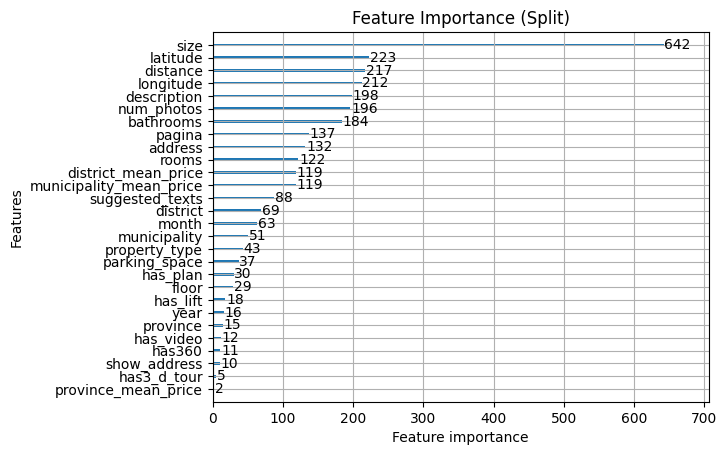

In [76]:
# Obter a importância das características
feature_importance_values = bst.feature_importance(importance_type='split')

# Criar um DataFrame para facilitar a visualização
feature_importances = pd.DataFrame({
    'feature': df7_val.drop(['price','pred'], axis = 1).columns.to_list(),
    'importance': feature_importance_values
})

# Ordenar as características pela importância
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Visualizar a importância das características
plt.figure(figsize=(10, 6))
lgb.plot_importance(bst, importance_type='split', max_num_features=30)
plt.title('Feature Importance (Split)')
plt.show()

In [83]:
y_teste_final = df7_val['price']
y_hat_final = df7_val['pred']

# performance
lgbm_result = ml_error( 'lgbm result',  y_teste_final  ,  y_hat_final  )
lgbm_result

,Model Name,MAE,MAPE,RMSE,R2_score
0,lgbm result,669.75,0.20,"1,334.64",0.82


In [84]:
# verificando as predições no dados de teste
df6_val['erro'] = df6_val['pred'] - df6_val['price']      
df6_val['erro_abs'] = df6_val['erro'].apply( lambda x : abs(x))
df6_val.sort_values( by = 'price', ascending = False )
df6_val[['price','pred','erro','erro_abs']].sort_values(by = 'erro_abs',ascending = False).head(20)


,price,pred,erro,erro_abs
1587,"33,000.00","8,560.90","-24,439.10","24,439.10"
412,"27,500.00","11,908.49","-15,591.51","15,591.51"
409,"24,000.00","12,598.28","-11,401.72","11,401.72"
263,"14,000.00","4,032.27","-9,967.73","9,967.73"
758,"27,500.00","18,119.73","-9,380.27","9,380.27"
886,"28,000.00","18,643.19","-9,356.81","9,356.81"
733,"29,000.00","19,704.29","-9,295.71","9,295.71"
221,"29,000.00","20,255.05","-8,744.95","8,744.95"
209,"18,000.00","10,817.83","-7,182.17","7,182.17"
173,"10,000.00","3,237.86","-6,762.14","6,762.14"


In [85]:
df6_val[['price','pred','erro','erro_abs']].sort_values(by = 'erro_abs',ascending = True).head(20)

,price,pred,erro,erro_abs
1604,"1,450.00","1,450.56",0.56,0.56
1219,"2,950.00","2,951.15",1.15,1.15
1663,"1,100.00","1,098.74",-1.26,1.26
1345,"1,200.00","1,201.48",1.48,1.48
924,"2,150.00","2,151.55",1.55,1.55
245,"9,750.00","9,747.94",-2.06,2.06
1089,"2,185.00","2,182.76",-2.24,2.24
1836,980.00,982.58,2.58,2.58
457,"1,600.00","1,602.91",2.91,2.91
1457,"1,700.00","1,696.64",-3.36,3.36


In [86]:
erros_acima_media  = df6_val.loc[ df6_val['erro_abs'] >= 611.53 , : ].count()
erros_abaixo_media = df6_val.loc[ df6_val['erro_abs'] <= 611.53 , : ].count()
print( f'Erros abaixo da média {erros_abaixo_media[0]}')
print( f'Erros acima da média {erros_acima_media[0]}' )

Erros abaixo da média 1408
Erros acima da média 592


In [87]:
df_teste[['price','property_type','num_photos']].sort_values( by = 'price' , ascending = False )

,price,property_type,num_photos
18003,"33,000.00",chalet,27.00
17149,"29,000.00",chalet,33.00
16637,"29,000.00",chalet,27.00
17302,"28,000.00",duplex,30.00
16828,"27,500.00",penthouse,67.00
...,...,...,...
17493,690.00,flat,16.00
18144,675.00,studio,6.00
17702,650.00,flat,6.00
16756,620.00,flat,12.00


In [88]:
df7[['price','property_type','num_photos']].sort_values( by = 'price' , ascending = False )

,price,property_type,num_photos
341,"80,000.00",0,32.00
9808,"35,000.00",0,15.00
8787,"33,000.00",0,23.00
4594,"33,000.00",0,61.00
11174,"29,000.00",0,38.00
...,...,...,...
37,450.00,2,14.00
735,450.00,3,19.00
7419,450.00,3,19.00
1704,400.00,5,7.00


## 8.1.3 Test com Dados Inseridos Manualmente

In [231]:
# vejo 
df_teste.loc[ 16640 ]

property_code                                                   32,747,235.00
thumbnail                   https://img3.idealista.pt/blur/WEB_LISTING/0/i...
num_photos                                                              24.00
floor                                                                     NaN
price                                                                1,500.00
property_type                                                            flat
operation                                                                rent
size                                                                   107.00
exterior                                                                False
rooms                                                                    2.00
bathrooms                                                                2.00
address                                                   Moscavide e Portela
province                                                        

In [362]:
test = {
'property_code': 0,
'thumbnail': 0,
'num_photos': 10,
'floor': 1,
'price' : 0,
'property_type': 'flat',
'operation': 'rent',
'size': 35,
'exterior': True,
'rooms': 1 ,
'bathrooms':1,
'address' : 'Rua 1º de Maio, n. 52',
'province': 'Lisboa',
'municipality': 'Moscavide e Portela',
'district' : np.nan,
'country': 'PT',
'latitude' : 38.775101412019715,
'longitude': -9.104655113802375,
'show_address': True,
'url': np.nan,
'distance': 9600,
'description' : 'Apartamento localizado na rua 1º de Maio. T1 remodelado, em frente ao metro, próximo a supermercados e ao parque das nações. 3 cauções adiantadas ou 2 fiadores',
'has_video' : False,
'status' : 'good',
'new_development' : False,
'has_lift': 1,
'price_by_area' : np.nan,
'detailed_type': {'typology': 'flat'},
'suggested_texts' : {'subtitle': 'Moscavide e Portela, Loures', 'title': 'Apartamento'},
'has_plan' : True,
'has3_d_tour': False,
'has360' : False,
'has_staging' : False,
'top_new_development' : False,
'super_top_highlight' : False,
'parking_space' : np.nan,
'external_reference':np.nan,
'labels' : np.nan,                                                                 
'neighborhood': np.nan,                                                         
'pagina' : 0,                                                                  
'datetime_scrapy':  pd.to_datetime('2023-05-05 10:18:37'),                                         
'new_development_finished': np.nan,                                                  
'highlight' : np.nan 

}

df_pred_test = pd.DataFrame( [test] )


In [351]:
def test_prediction( df , model ):
    # instancia a classe Idealista
    idealista_1 = Idealista()

    # limpando os dados
    df1_val = idealista_1.transform_data( df , colunas_irrelevantes )

    # feature engineering
    df2_val = idealista_1.feature_engineering( df1_val , transform_data = True, merge_datasets = True )

    # filtrar variáveis
    df3_val = idealista_1.filter_variables( df2_val )

    # reomver outliers
    df4_val = idealista_1.remove_outliers( df3_val )

    # reescalar dados
    df5_val = idealista_1.rescaling_data( df4_val )

    # encodar dados
    df6_val = idealista_1.encoding( df5_val )

    # predicoes
    df7_val = idealista_1.predicoes( df6_val ,model )
    
    return df7_val

In [363]:
a = test_prediction( df_pred_test , bst )

C:\Users\oscar\AppData\Local\Temp\ipykernel_7416\2764531685.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'thumbnail'] = np.where( df['thumbnail'].isna(), 0 , 1 )


datasets combinados e dados transformados
Variavies não filtradas
Outliers mantidos
Not rescaled


C:\Users\oscar\AppData\Local\Temp\ipykernel_7416\2764531685.py:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'parking_space'] = df['parking_space'].apply( lambda x: 0 if pd.isna( x ) else x )


In [372]:
a['pred']

0   924.69
Name: pred, dtype: float64